In [13]:
from qiskit import *
import numpy as np
from QArithmetic import sub_swap
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_finance.circuit.library import LogNormalDistribution

In [14]:
def bitwise_or_one(qc, a, b, c):
    qc.ccx(a, b, c)
    qc.cx(a, c)
    qc.cx(b, c)

In [15]:
#the size of a must be exactly smaller than b by one. How to fix this?
#b2 can not make connection with carry 2
def logic_adder(qc, a, b, c):
    #qc.barrier()
    n = a.size
    for i in range(n-1):
        qc.ccx(a[i], b[i], c[i+1])
        qc.cx(a[i],b[i])
        if i!= 0:
            qc.ccx(c[i], b[i], c[i+1])
    if a.size - b.size == -1: #when size differene becomes 2, the last qubit of b can not be used currently.
        qc.ccx(a[n-1], b[n-1], b[n])
        qc.cx(a[n-1], b[n-1])
    
    if n!= 1:
        qc.ccx(c[n-1], b[n-1], b[n])
        qc.cx(c[n-1], b[n-1])
    
    for i in range(n-1):
        qc.ccx(c[(n-2)-i], b[(n-2)-i], c[(n-1)-i])
        qc.cx(a[(n-2)-i], b[(n-2)-i])
        qc.ccx(a[(n-2)-i], b[(n-2)-i], c[(n-1)-i])
        qc.cx(c[(n-2)-i], b[(n-2)-i])
        qc.cx(a[(n-2)-i], b[(n-2)-i])
        qc.ccx(c[i], b[i], c[i+1])


In [16]:
qc = QuantumCircuit()
registers = []
n = 1
num_register = 1
for i in range(num_register):
    registers.append(QuantumRegister(n, name = "r_step " + str(i)))
    n = n + 1
for i in range(num_register):
    qc.add_register(registers[i])
    qc.h(registers[i][0])
c = QuantumRegister(n, name = "carry") #Carry bits
qc.add_register(c)

#Implementing a carry gate that is applied on all (c[i], a[i], b[i]) #with output fed to c[i+1]
for j in range(num_register-1):
    a = registers[j]
    b = registers[j+1]
    logic_adder(qc, a, b)

In [17]:
registers.append(QuantumRegister(2, name = "xi_step " + str(i)))
qc.add_register(registers[-1])
qc.h(registers[-1][1])
    
# we need to consider carry qubits here
#Implementing a carry gate that is applied on all (c[i], a[i], b[i]) #with output fed to c[i+1]
n = 1
for j in range(num_register, num_register + num_register - 1): #no final one for first adder
    a = registers[j]
    b = registers[j+1]
    logic_adder(qc, a, b)

In [18]:
#Theta
registers.append(QuantumRegister(2, name="theta"))
qc.add_register(registers[-1])
qc.x(registers[-1][1])


#Integral for r
registers.append(QuantumRegister(3, name = "sum")) 
qc.add_register(registers[-1])
n = 1
for j in range(num_register):  #The last number also needs to be a
    a = registers[j]
    b = registers[-1]
    for i in range(n-1):
        qc.ccx(a[i], b[i], c[i+1])
        qc.cx(a[i],b[i])
        qc.ccx(c[i], b[i], c[i+1])
    #For the last iteration of the carry gate, instead of feeding the #result to c[n], we use b[n], which is why c has only n bits, with #c[n-1] being the last carry bit
    qc.ccx(a[n-1], b[n-1], b[n])
    qc.cx(a[n-1], b[n-1])
    qc.ccx(c[n-1], b[n-1], b[n])
    
    #Reversing the gate operation performed on b[n-1]
    qc.cx(c[n-1], b[n-1])
    #Reversing the gate operations performed during the carry gate implementations
    #This is done to ensure the sum gates are fed with the correct input bit states
    for i in range(n-1):
        qc.ccx(c[(n-2)-i], b[(n-2)-i], c[(n-1)-i])
        qc.cx(a[(n-2)-i], b[(n-2)-i])
        qc.ccx(a[(n-2)-i], b[(n-2)-i], c[(n-1)-i])
        #These two operations act as a sum gate; if a control bit is at                
        #the 1> state then the target bit b[(n-2)-i] is flipped
        qc.cx(c[(n-2)-i], b[(n-2)-i])
        qc.cx(a[(n-2)-i], b[(n-2)-i])
    n = n+1


    
#Integral for xi (theta dW)
n = 2
for j in range(num_register, num_register + num_register):  #The last number also needs to be a
    a = registers[j]
    b = registers[-1]
    for i in range(n-1):
        qc.ccx(a[i], b[i], c[i+1])
        qc.cx(a[i],b[i])
        qc.ccx(c[i], b[i], c[i+1])
    #For the last iteration of the carry gate, instead of feeding the #result to c[n], we use b[n], which is why c has only n bits, with #c[n-1] being the last carry bit
    qc.ccx(a[n-1], b[n-1], b[n])
    qc.cx(a[n-1], b[n-1])
    qc.ccx(c[n-1], b[n-1], b[n])
    
    #Reversing the gate operation performed on b[n-1]
    qc.cx(c[n-1], b[n-1])
    #Reversing the gate operations performed during the carry gate implementations
    #This is done to ensure the sum gates are fed with the correct input bit states
    for i in range(n-1):
        qc.ccx(c[(n-2)-i], b[(n-2)-i], c[(n-1)-i])
        qc.cx(a[(n-2)-i], b[(n-2)-i])
        qc.ccx(a[(n-2)-i], b[(n-2)-i], c[(n-1)-i])
        #These two operations act as a sum gate; if a control bit is at                
        #the 1> state then the target bit b[(n-2)-i] is flipped
        qc.cx(c[(n-2)-i], b[(n-2)-i])
        qc.cx(a[(n-2)-i], b[(n-2)-i])
    n = n+1

    
# registers.append(QuantumRegister(int(np.log2(num_register))+1, name="theta"))
# registers[-1].x([1,1])

# qc.add_register(registers[-1])
# add theta 
qc.barrier()
a = registers[-2] #theta
b = registers[-1]
n = a.size
for i in range(n-1):
    qc.ccx(a[i], b[i], c[i+1])
    qc.cx(a[i],b[i])
    qc.ccx(c[i], b[i], c[i+1])
#For the last iteration of the carry gate, instead of feeding the #result to c[n], we use b[n], which is why c has only n bits, with #c[n-1] being the last carry bit
qc.ccx(a[n-1], b[n-1], b[n])
qc.cx(a[n-1], b[n-1])
qc.ccx(c[n-1], b[n-1], b[n])

#Reversing the gate operation performed on b[n-1]
qc.cx(c[n-1], b[n-1])
#Reversing the gate operations performed during the carry gate implementations
#This is done to ensure the sum gates are fed with the correct input bit states
for i in range(n-1):
    qc.ccx(c[(n-2)-i], b[(n-2)-i], c[(n-1)-i])
    qc.cx(a[(n-2)-i], b[(n-2)-i])
    qc.ccx(a[(n-2)-i], b[(n-2)-i], c[(n-1)-i])
    #These two operations act as a sum gate; if a control bit is at                
    #the 1> state then the target bit b[(n-2)-i] is flipped
    qc.cx(c[(n-2)-i], b[(n-2)-i])
    qc.cx(a[(n-2)-i], b[(n-2)-i])


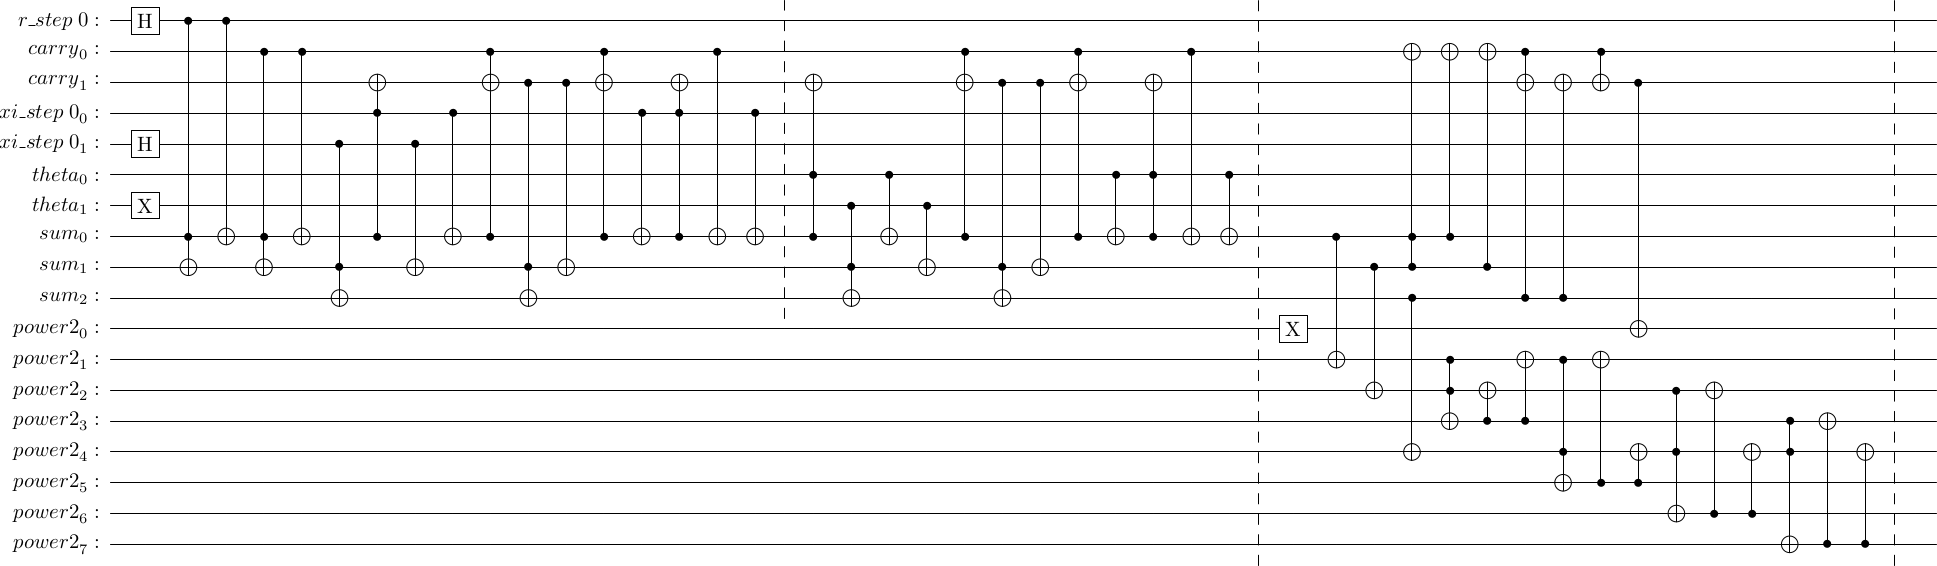

In [19]:
a = registers[-1]
b = QuantumRegister(8, "power2")
registers.append(b)
qc.add_register(b)

qc.barrier()
qc.x(b[0])
# qc.cx(a[0],b[0])
# qc.x(a[0])

# qc.barrier()
qc.cx(a[0],b[1])
qc.cx(a[1],b[2])
qc.cx(a[2],b[4])

# qc.barrier()
qc.ccx(b[1],b[2],b[3])
qc.cx(b[3],b[2])
qc.cx(b[3],b[1])

# qc.barrier()
qc.ccx(b[1],b[4],b[5])
qc.cx(b[5],b[1])
qc.cx(b[5],b[4])


# qc.barrier()
qc.ccx(b[2],b[4],b[6])
qc.cx(b[6],b[2])
qc.cx(b[6],b[4])

# qc.barrier()
qc.ccx(b[3],b[4],b[7])
qc.cx(b[7],b[3])
qc.cx(b[7],b[4])
# qc.barrier()
bitwise_or_one(qc, a[0], a[1], c[0])
bitwise_or_one(qc, a[2], c[0], c[1])
qc.cx(c[1], b[0])
# qc.ccx(b[1],b[2],b[3])
# qc.cx(a[2],b[4])

qc.barrier()
# qc.measure_all(b)
qc.draw("latex")

In [20]:
m = QuantumRegister(6, "multiplier")
qc.add_register(m)
qc.x(m[0])
sub_swap(qc, b, m, 6)
qc.x(m[0])

In [21]:
for i in range(m.size):
    qc.ccx(registers[1][1], b[i], m[i])
registers.append(m)

In [22]:
# #Measure qubits and store results in classical register cl
# # n = 1
# cl = ClassicalRegister(registers[-1].size) #Classical output
# qc.add_register(cl)
# for i in range(registers[-1].size):
#     print(i)
#     qc.measure(registers[-1][i], cl[i])

# num_shots = 100 #Setting the number of times to repeat measurement
# backend = Aer.get_backend("qasm_simulator")
# job = execute(qc, backend, shots=num_shots)
# #Get results of program
# job_stats = job.result().get_counts()
# print(job_stats)

# # import basic plot tools
# from qiskit.visualization import plot_histogram
# plt.style.use('ieee')
# plt.rcParams['font.size'] = '14'
# plot_histogram(job_stats)

In [23]:
registers.append(QuantumRegister(1, name="amplititude"))
qc.add_register(registers[-1])

#We should not know other data except the number of qubits.
num_uncertainty_qubits = registers[-2].size
slopes = 1 
low = 0
high = 1
offsets = 0
f_min = 0

f_max = 1

european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max)
)

qc.append(european_call_objective, range(qc.width() - registers[-1].size - registers[-2].size, qc.width()))

In [24]:
epsilon = 0.01
alpha = 0.05
qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = EstimationProblem(
    state_preparation=qc,
    objective_qubits=[qc.width()-1],
    post_processing=european_call_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)

In [ ]:
result = ae.estimate(problem)

In [ ]:
import math
result.estimation_processed* 255 / math.pi